In [1]:
import os
import pandas as pd
import numpy as np
os.chdir('/home/scur2012/Thesis/master-thesis/results')

In [2]:
from tbparse import SummaryReader
mvts = "pretraining/transformer_mvts/tb_logs/version_0"     # Batch size 32
vit = "pretraining/vanilla_vit_1d/tb_logs/version_0"        # Batch size 64
unet = "pretraining/unet_peregrine/tb_logs/version_0"       # Batch size 256

df_mvts = SummaryReader(mvts).scalars
df_vit = SummaryReader(vit).scalars
df_unet = SummaryReader(unet).scalars


In [3]:
def average_every_n_rows(df, column_name, n):
    """
    Averages every n rows in a DataFrame column.
    
    Parameters:
    df (pd.DataFrame): The original DataFrame.
    column_name (str): The name of the column to average.
    n (int): The number of rows to average over.

    Returns:
    pd.DataFrame: A new DataFrame with the averaged values.
    """
    # Calculate the number of groups
    num_groups = len(df) // n

    # Group the DataFrame and calculate the mean for each group
    averaged_data = df[column_name].groupby(np.arange(len(df)) // n).mean()

    # Convert the result to a new DataFrame
    result_df = pd.DataFrame({column_name: averaged_data})

    return result_df

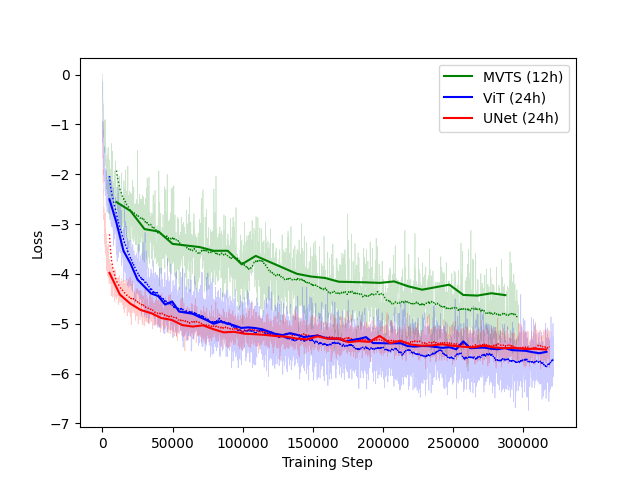

In [45]:
# Plot train validation loss

import matplotlib.pyplot as plt
%matplotlib widget

df_mvts_train = df_mvts[(df_mvts['tag'] == 'train_loss') & (df_mvts['step'] < df_mvts['step'].max()//2  ) ]
df_vit_train =  df_vit[(df_vit['tag'] == 'train_loss') & (df_vit['step'] < df_mvts['step'].max()  ) ]
df_unet_train =  df_unet[(df_unet['tag'] == 'train_loss') & (df_unet['step'] < df_mvts['step'].max()  ) ]

df_mvts_val =  df_mvts[(df_mvts['tag'] == 'val_loss') & (df_mvts['step'] < df_mvts['step'].max()//2  ) ]
df_vit_val =  df_vit[(df_vit['tag'] == 'val_loss') & (df_vit['step'] < df_mvts['step'].max()  ) ]
df_unet_val = df_unet[(df_unet['tag'] == 'val_loss') & (df_unet['step'] < df_mvts['step'].max()  ) ]

plt.close(1), plt.figure(1)
plt.plot(df_mvts_train['step'], df_mvts_train['value'], color='g', alpha=0.2, linewidth=0.5)
plt.plot(df_vit_train['step'], df_vit_train['value'], color='b', alpha=0.2, linewidth=0.5)
plt.plot(df_unet_train['step'], df_unet_train['value'], color='r', alpha=0.2, linewidth=0.5)

plt.plot(df_mvts_train['step'], df_mvts_train['value'].rolling(100).mean(), color='g', linestyle='dotted', linewidth=1)
plt.plot(df_vit_train['step'], df_vit_train['value'].rolling(100).mean(), color='b', linestyle='dotted', linewidth=1)
plt.plot(df_unet_train['step'], df_unet_train['value'].rolling(100).mean(), color='r', linestyle='dotted', linewidth=1)

plt.plot(df_mvts_val['step'], df_mvts_val['value'], label='MVTS (12h)', color='g')
plt.plot(df_vit_val['step'], df_vit_val['value'], label='ViT (24h)', color='b')
plt.plot(df_unet_val['step'], df_unet_val['value'], label='UNet (24h)', color='r')

plt.legend()

plt.xlabel('Training Step')
plt.ylabel('Loss')

plt.savefig('Pretraining_loss_curve.png', dpi=600, bbox_inches='tight')

plt.show()

In [92]:
# Table of AUROC curve values. 3 networks, 15 parameters
import duckdb

intrinsic_variables = ['mass_ratio', 'chirp_mass', 'theta_jn', 'phase', 'tilt_1', 'tilt_2', 'a_1', 'a_2', 'phi_12', 'phi_jl']
extrinsic_variables = ['luminosity_distance', 'dec', 'ra', 'psi', 'geocent_time']

with duckdb.connect(database=':memory:') as conn:
    
    query = f"""   
        
        WITH mvts AS (
            SELECT tag, step, value
            FROM df_mvts
            WHERE step = (SELECT MAX(step) FROM df_mvts WHERE tag LIKE 'val_loss_feature%') AND tag LIKE 'val_loss_feature%'
        ), 
        vit AS (
            SELECT tag, step, value
            FROM df_vit
            WHERE step = (SELECT MAX(step) FROM df_vit WHERE tag LIKE 'val_loss_feature%') AND tag LIKE 'val_loss_feature%'
        ), 
        unet AS (
            SELECT tag, step, value
            FROM df_unet
            WHERE step = (SELECT MAX(step) FROM df_unet WHERE tag LIKE 'val_loss_feature%') AND tag LIKE 'val_loss_feature%'
        )
        
        SELECT
            CASE 
                {" ".join([f"WHEN mvts.tag = 'val_loss_feature_{i}' THEN '{name}'" for i,name in enumerate(
                    intrinsic_variables+extrinsic_variables)])}
            END AS feature,
            mvts.value AS mvts, 
            vit.value AS vit, 
            unet.value AS unet
        
        FROM mvts
        JOIN vit
          ON  mvts.tag = vit.tag
        JOIN unet
          ON  mvts.tag = unet.tag
        
    """
    
    val_loss = conn.execute(query).df()


val_loss_formatted = val_loss.set_index('feature').loc[intrinsic_variables+extrinsic_variables].reset_index()

In [95]:
# Convert to latex table
print(val_loss_formatted.to_latex(float_format="%.3f", bold_rows=True, index=False, caption='Loss values for each of the features') )


\begin{table}
\caption{Loss values for each of the features}
\begin{tabular}{lrrr}
\toprule
feature & mvts & vit & unet \\
\midrule
mass_ratio & -0.231 & -0.295 & -0.300 \\
chirp_mass & -0.542 & -0.676 & -0.701 \\
theta_jn & -0.327 & -0.463 & -0.426 \\
phase & 0.000 & 0.000 & 0.000 \\
tilt_1 & -0.107 & -0.167 & -0.174 \\
tilt_2 & -0.018 & -0.036 & -0.036 \\
a_1 & -0.078 & -0.104 & -0.132 \\
a_2 & -0.005 & -0.008 & -0.007 \\
phi_12 & 0.000 & 0.000 & 0.000 \\
phi_jl & -0.199 & -0.291 & -0.287 \\
luminosity_distance & -0.196 & -0.294 & -0.291 \\
dec & -0.830 & -0.923 & -0.899 \\
ra & -1.020 & -1.085 & -1.066 \\
psi & -0.063 & -0.117 & -0.090 \\
geocent_time & -0.965 & -1.104 & -1.105 \\
\bottomrule
\end{tabular}
\end{table}



In [3]:
import duckdb

intrinsic_variables = ['mass_ratio', 'chirp_mass', 'theta_jn', 'phase', 'tilt_1', 'tilt_2', 'a_1', 'a_2', 'phi_12', 'phi_jl']
extrinsic_variables = ['luminosity_distance', 'dec', 'ra', 'psi', 'geocent_time']

with duckdb.connect(database=':memory:') as conn:
    df_main = conn.execute("""
        SELECT * 
        FROM df 
        WHERE tag = 'train_loss' OR tag = 'val_loss'
    """).df()
    
    df_val_loss_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'val_loss_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'val_loss_feature%'
    """).df()

    df_train_loss_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'train_loss_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'train_loss_feature%'
    """).df()
    
    df_features2 = conn.execute("""
        SELECT * 
        FROM df_val_loss_features 
        WHERE feature IN (
            SELECT feature
            FROM df_val_loss_features
            GROUP BY feature
            HAVING MIN(value) < -0.3
        )
    """).df()
    df_features1 = conn.execute("""
        SELECT * 
        FROM df_val_loss_features 
        WHERE feature IN (
            SELECT feature
            FROM df_val_loss_features
            GROUP BY feature
            HAVING MIN(value) BETWEEN -0.3 AND -0.005
        )
    """).df()
    
df_features1

,step,value,feature
0,9999,-0.120949,mass_ratio
1,19999,-0.128823,mass_ratio
2,29999,-0.136932,mass_ratio
3,39999,-0.136099,mass_ratio
4,49999,-0.137416,mass_ratio
...,...,...,...
395,544338,-0.194355,phi_jl
396,554338,-0.201682,phi_jl
397,564338,-0.204096,phi_jl
398,574338,-0.202618,phi_jl


In [4]:
df['tag'].unique()

array(['epoch', 'lr-Adam', 'train_loss', 'train_loss_feature_0',
       'train_loss_feature_1', 'train_loss_feature_10',
       'train_loss_feature_11', 'train_loss_feature_12',
       'train_loss_feature_13', 'train_loss_feature_14',
       'train_loss_feature_2', 'train_loss_feature_3',
       'train_loss_feature_4', 'train_loss_feature_5',
       'train_loss_feature_6', 'train_loss_feature_7',
       'train_loss_feature_8', 'train_loss_feature_9', 'val_loss',
       'val_loss_feature_0', 'val_loss_feature_1', 'val_loss_feature_10',
       'val_loss_feature_11', 'val_loss_feature_12',
       'val_loss_feature_13', 'val_loss_feature_14', 'val_loss_feature_2',
       'val_loss_feature_3', 'val_loss_feature_4', 'val_loss_feature_5',
       'val_loss_feature_6', 'val_loss_feature_7', 'val_loss_feature_8',
       'val_loss_feature_9'], dtype=object)

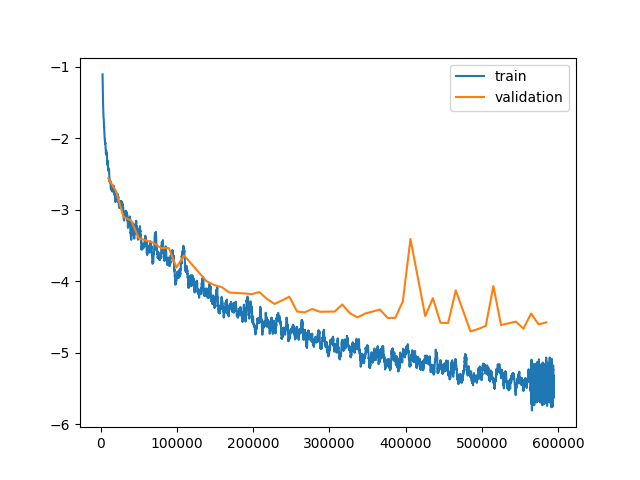

In [5]:
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

train_loss = df_main[df_main['tag'] == 'train_loss'].copy()
train_loss['smoothed'] = train_loss['value'].rolling(25).mean()
val_loss = df_main[df_main['tag'] == 'val_loss']

plt.close(1), plt.figure(1)
plt.plot(train_loss['step'], train_loss['smoothed'], label='train')
plt.plot(val_loss['step'], val_loss['value'], label='validation')
plt.legend()

plt.show()

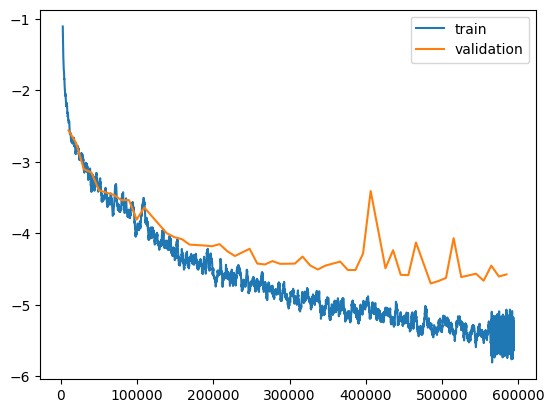

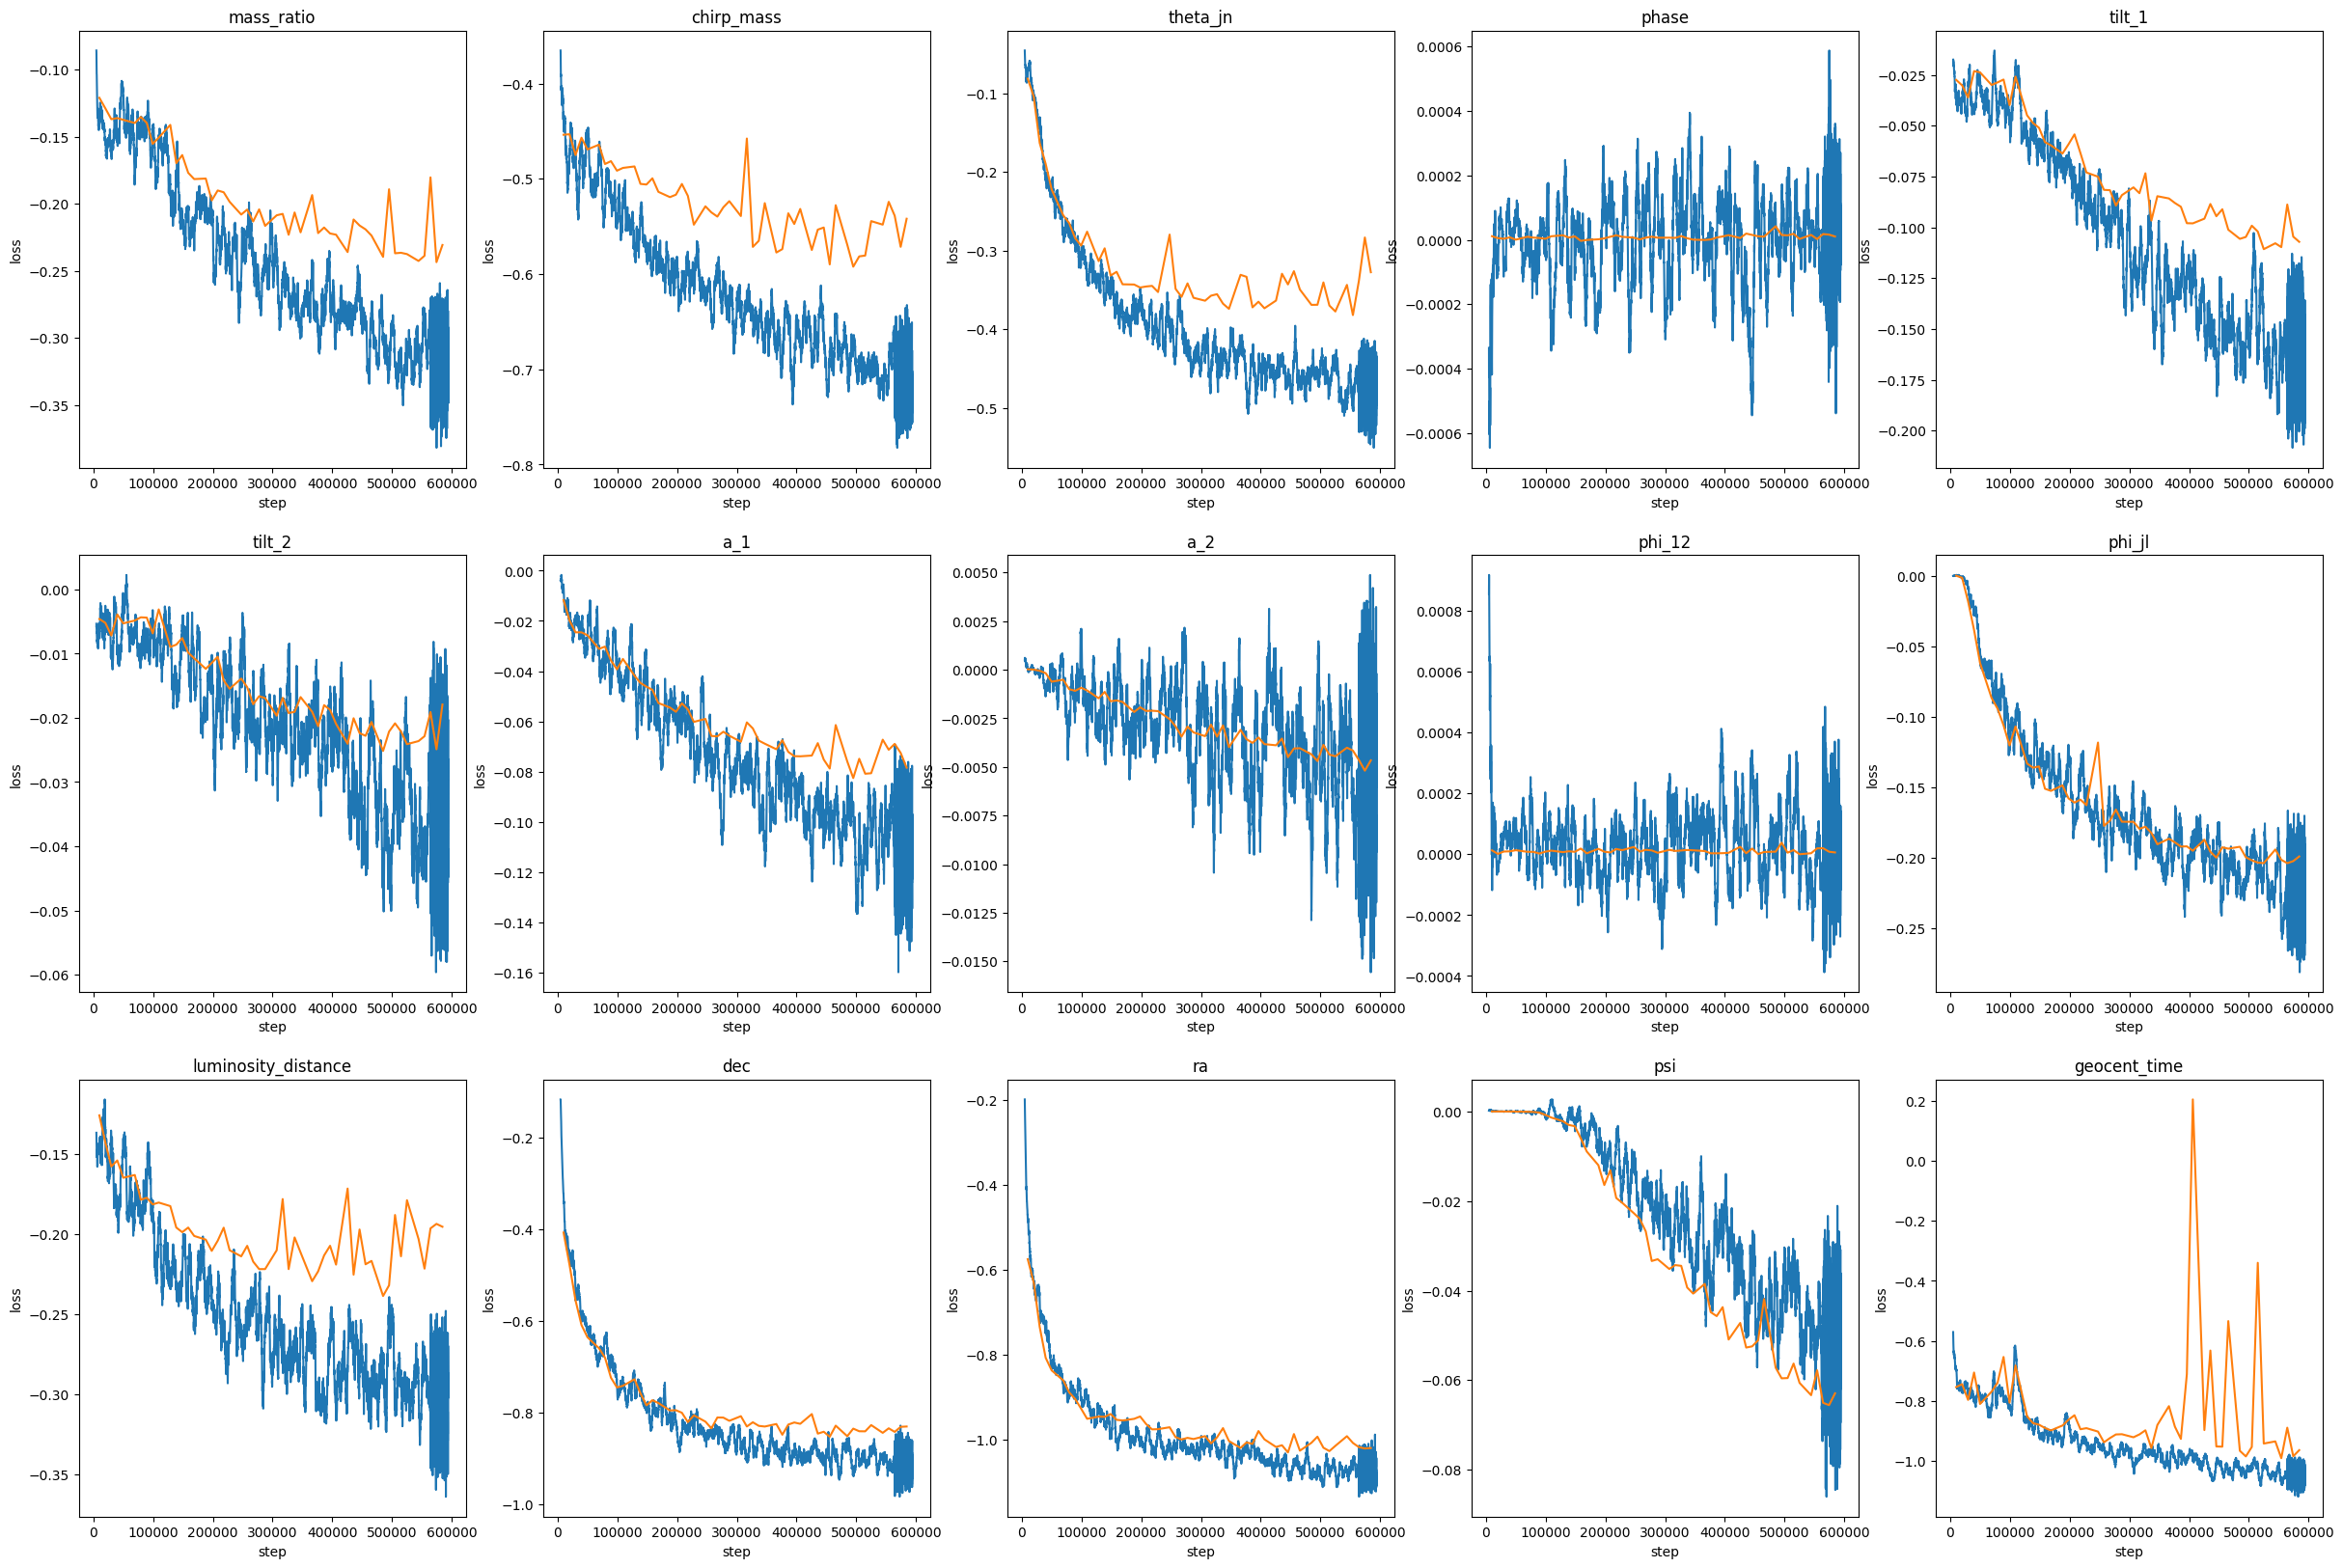

No such comm: eb3cb2b66d99403c94bbd8cb5c981826
No such comm: eb3cb2b66d99403c94bbd8cb5c981826
No such comm: eb3cb2b66d99403c94bbd8cb5c981826
No such comm: eb3cb2b66d99403c94bbd8cb5c981826


In [6]:
%matplotlib inline

plt.figure(2, figsize=(30, 20))
        
# Intrinsic variables plotting
for i, name in enumerate(intrinsic_variables+extrinsic_variables):
    ax = plt.subplot(3, 5, i + 1)
    plt.xlabel('step')
    plt.ylabel('loss')
    
    train_data = df_train_loss_features[df_train_loss_features['feature']==name].copy()
    train_data['smoothed'] = train_data['value'].rolling(50).mean()
    
    val_data = df_val_loss_features[df_val_loss_features['feature']==name]
    
    plt.title(name)
    plt.plot(train_data['step'], train_data['smoothed'], label='train')
    plt.plot(val_data['step'], val_data['value'], label='val')

<Axes: xlabel='step', ylabel='value'>

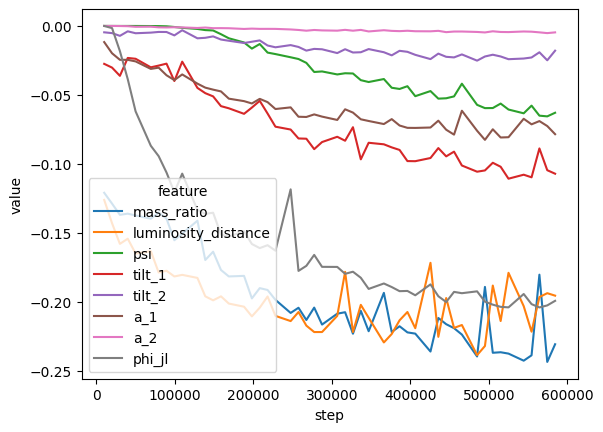

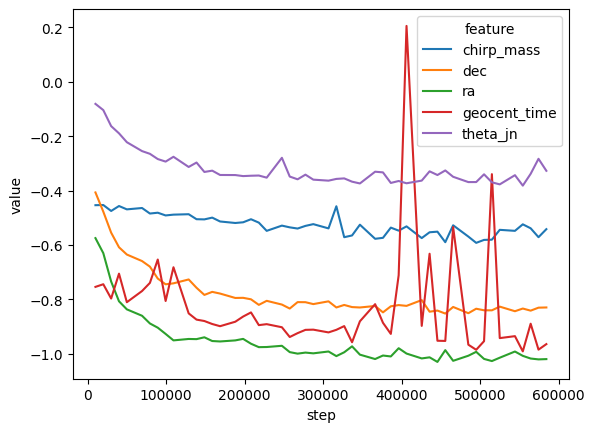

In [7]:
%matplotlib inline

plt.close(2), plt.figure(2)
sns.lineplot(data=df_features1, x='step', y='value', hue='feature')

plt.close(3), plt.figure(3)
sns.lineplot(data=df_features2, x='step', y='value', hue='feature')